In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.simplefilter(action='ignore')

#### pystan windows C++ compiler

* conda install libpython m2w64-toolchain -c msys2 --yes

In [2]:
import os
import platform
import pystan

dependencies_installed = True
if platform.system() == 'Windows' and not dependencies_installed:
    os.system("conda install libpython m2w64-toolchain -c msys2 --yes")

### pystan leveraged by fbprophet need to test before using kats
if not dependencies_installed:
    model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
    model = pystan.StanModel(model_code=model_code)  # this will take a minute
    y = model.sampling(n_jobs=1).extract()['y']
    print(y.mean())  # should be close to 0

#### Kats Time Series Features

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kats.consts import TimeSeriesData
from kats.utils.simulator import Simulator
from kats.tsfeatures.tsfeatures import TsFeatures

random_seed = 100
np.random.seed(random_seed)
sim = Simulator(n=90,freq="D",start="2021-01-01")
num_ts_data = 10
arima_sim_list = [sim.arima_sim(ar=[0.1,0.05],ma=[0.04,0.1],d=1) for _ in range(num_ts_data)]
trend_sim_list = [
    sim.trend_shift_sim(
        cp_arr=[30,60,75],
        trend_arr=[3,15,2,8],
        intercept=30,
        noise=50,
        seasonal_period=7,
        seasonal_magnitude=np.random.uniform(10,100),
        random_seed=random_seed
    ) for _ in range(num_ts_data)
]
level_shift_list = [
    sim.level_shift_sim(
        cp_arr=[30,60,75],
        level_arr=[1.35,1.05,1.35,1.2],
        noise=0.05,
        seasonal_period=7,
        seasonal_magnitude=np.random.uniform(0.1,1.0),
        random_seed=random_seed
    ) for _  in range(num_ts_data)
]
ts_list = arima_sim_list + trend_sim_list + level_shift_list 

#### Single Time Series

INFO:root:Plotting time series


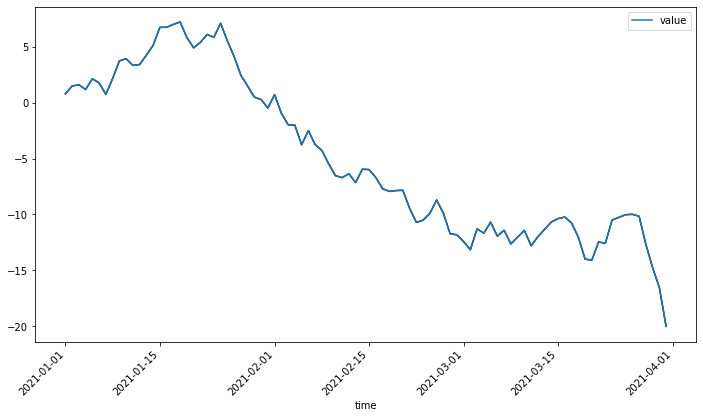

In [6]:
ts = ts_list[0]
ts.plot(cols=['value'])
plt.xticks(rotation=45)
plt.show();

In [12]:
model = TsFeatures()
output_features = model.transform(ts)
df_uni_features = pd.DataFrame([output_features])
df_uni_features.head()

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,binarize_mean,unitroot_kpss,heterogeneity,histogram_mode,linearity,trend_strength,seasonality_strength,spikiness,peak,trough,level_shift_idx,level_shift_size,y_acf1,y_acf5,diff1y_acf1,diff1y_acf5,diff2y_acf1,diff2y_acf5,y_pacf5,diff1y_pacf5,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,90,-4.973228,50.694998,0.274245,10.25821,45.077604,1,0.418844,0.877359,5,0.433333,0.416411,73.295272,-11.841676,0.834636,0.985303,0.352196,0.000205,1,6,23,0.713434,0.959758,4.036183,0.183023,0.079476,-0.481691,0.244768,0.986259,0.079818,0.361458,0.814998,0.030345,53,30,1.0,0.136561,NaN,NaN,NaN


#### Applications with Multiple Time Series

* can omit features e.g. **TsFeatures(seasonality_strength=False)**

In [11]:
multi_model = TsFeatures()
multi_output_features = [multi_model.transform(uni_ts) for uni_ts in ts_list]
df_features = pd.DataFrame(multi_output_features)
df_features.head()

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,binarize_mean,unitroot_kpss,heterogeneity,histogram_mode,linearity,trend_strength,seasonality_strength,spikiness,peak,trough,level_shift_idx,level_shift_size,y_acf1,y_acf5,diff1y_acf1,diff1y_acf5,diff2y_acf1,diff2y_acf5,y_pacf5,diff1y_pacf5,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,90,-4.973228,50.694998,0.274245,10.258210,45.077604,1,0.418844,0.877359,5,0.433333,0.416411,73.295272,-11.841676,0.834636,0.985303,0.352196,0.000205,1,6,23,0.713434,0.959758,4.036183,0.183023,0.079476,-0.481691,0.244768,0.986259,0.079818,0.361458,0.814998,0.030345,53,30,1.000000,1.365608e-01,NaN,NaN,NaN
1,90,-2.058767,10.041589,0.366121,23.888037,5.711696,1,0.449241,0.701685,8,0.411111,0.397272,61.437672,-5.456243,0.144855,0.962898,0.369521,0.000022,5,2,69,0.566508,0.902696,2.726653,-0.091535,0.062756,-0.625373,0.451010,0.870669,0.068862,0.749517,0.327535,-0.226641,21,11,0.866466,9.110260e-02,NaN,NaN,NaN
2,90,9.908474,54.513387,0.371858,44.741126,45.977900,1,0.249448,0.983165,3,0.488889,0.338205,78.065196,10.116202,0.787592,0.984925,0.378044,0.000197,4,1,21,0.653428,0.947841,3.504109,0.291699,0.177916,-0.428888,0.233229,0.936070,0.166344,0.324193,0.668572,0.124300,55,31,1.000000,2.668360e-01,NaN,NaN,NaN
3,90,-4.852956,21.728208,0.492625,9.067492,16.945737,1,0.377345,0.705047,11,0.600000,0.816956,78.428172,-2.517814,0.612783,0.973171,0.174180,0.000090,2,6,69,0.556931,0.928283,3.114044,0.000746,0.088747,-0.628944,0.612680,0.901193,0.082085,0.533415,0.524764,0.009480,31,27,1.000000,1.520135e-12,NaN,NaN,NaN
4,90,-1.521848,28.601801,0.402300,259.161089,17.962647,1,0.543165,0.880529,6,0.366667,0.770582,75.763265,-3.471386,0.132895,0.982579,0.423375,0.000087,5,0,69,0.876386,0.921949,2.918618,0.212760,0.144393,-0.530624,0.420991,0.891398,0.138309,0.460363,0.398363,-0.106916,25,16,1.000000,1.024160e-01,NaN,NaN,NaN


#### Largest Seasonal Component

* leverage **TsFeatures** to find the time series data with the highest 'seasonality_strength'

INFO:root:Plotting time series


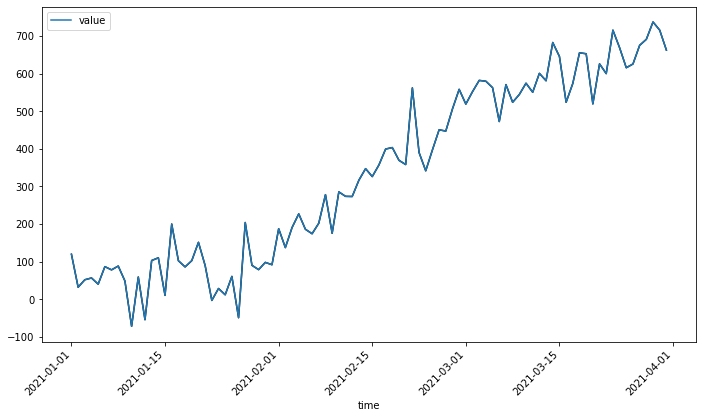

In [13]:
idx_target_ts = df_features['seasonality_strength'].argmax()
max_seas_str_ts = ts_list[idx_target_ts]
max_seas_str_ts.plot(cols=['value'])
plt.xticks(rotation=45)
plt.show();

#### Seasonal-Trend decomposition using LOESS (locally estimated scatterplot smoothing)

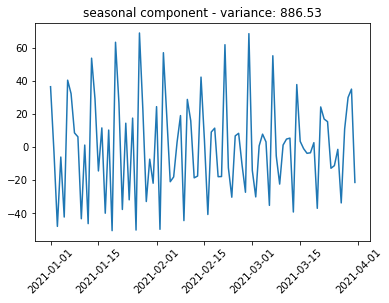

In [16]:
stl = STL(max_seas_str_ts.value.values,period=7)
res = stl.fit()
plt.plot(pd.to_datetime(max_seas_str_ts.time.values),res.seasonal)
plt.xticks(rotation=45)
plt.title(f'seasonal component - variance: {np.round(np.var(res.seasonal),2)}');

#### Cluster Similar Time Series

* In this example we pick 5 features and use PCA to project this representation into 2D

<Figure size 576x432 with 0 Axes>

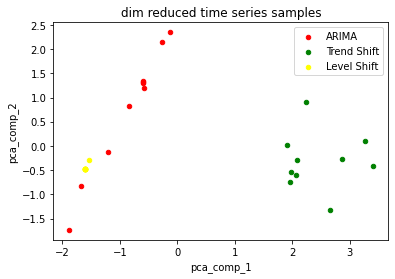

In [22]:
ls_features = ['lumpiness','entropy','seasonality_strength','stability','level_shift_size']
df_dataset = df_features[ls_features]
scaled_df_dataset_values = StandardScaler().fit_transform(df_dataset.values)
x_2d = PCA(n_components=2).fit_transform(X=scaled_df_dataset_values)
pca_comp1, pca_comp2 = 'pca_comp_1', 'pca_comp_2'
df_dataset[pca_comp1], df_dataset[pca_comp2] = x_2d[:,0], x_2d[:,1]
plt.figure(figsize=(8,6))
ax = df_dataset.iloc[0:10].plot(x=pca_comp1,y=pca_comp2,kind='scatter',color='red')
df_dataset.iloc[10:20].plot(x=pca_comp1,y=pca_comp2,kind='scatter',color='green',ax=ax)
df_dataset.iloc[20:].plot(x=pca_comp1,y=pca_comp2,kind='scatter',color='yellow',ax=ax)
plt.title('dim reduced time series samples')
plt.legend(['ARIMA','Trend Shift','Level Shift'])
plt.show();

#### Feature Group Mapping

* can omit feature groups and features together e.g. **TsFeatures(length=False,mean=False,stl_features=False)**
* can opt in e.g. **TsFeatures(selected_features=['mean','var','entropy'])**

In [37]:
from pprint import pprint

feat_group_map = TsFeatures().feature_group_mapping
feat_group_map_key_list = sorted(list(feat_group_map.keys()),reverse=False)
print(feat_group_map_key_list[0])
pprint(feat_group_map[feat_group_map_key_list[0]])

acfpacf_features
['y_acf1',
 'y_acf5',
 'diff1y_acf1',
 'diff1y_acf5',
 'diff2y_acf1',
 'diff2y_acf5',
 'y_pacf5',
 'diff1y_pacf5',
 'diff2y_pacf5',
 'seas_acf1',
 'seas_pacf1']
